# Esimate paramater for Normal distribution


In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

## preparing observation data


In [2]:
SAMPLE_SIZE = 100_000
MEAN = 10
SCALE = 3

# N(10, 9)
population = np.random.normal(MEAN, SCALE, SAMPLE_SIZE)
observation = population[np.random.randint(0, SAMPLE_SIZE, 1000)]

In [3]:
burn_in = int(0.25 * SAMPLE_SIZE)
burn_in

25000

Text(0.5, 0, 'data')

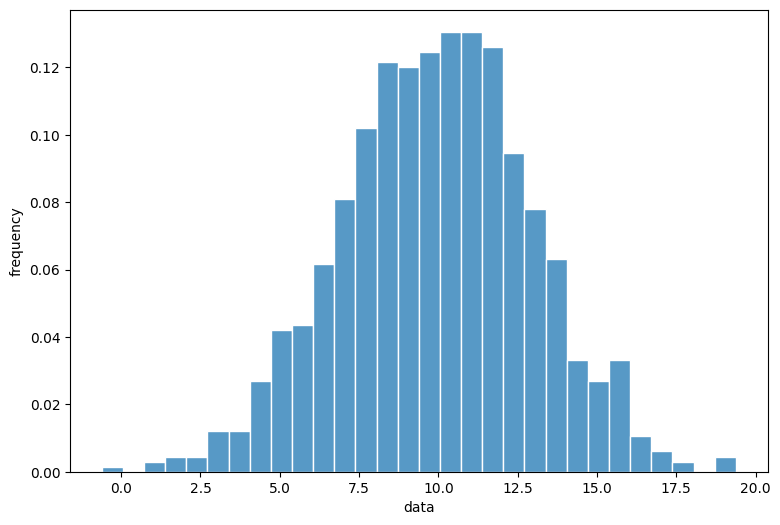

In [4]:
plt.figure(figsize=(9, 6))
sns.histplot(observation, stat="density", bins=30, edgecolor="w")
plt.ylabel("frequency")
plt.xlabel("data")

In [5]:
print(f"Mean of observation data: {observation.mean()}")
print(f"std of observation data: {np.sqrt(observation.var())}")

Mean of observation data: 9.922876641924061
std of observation data: 3.003896935561229


In [6]:
# running mean
def RunningMeans(sample):
    cumulative_sum = np.cumsum(sample)
    indices = np.arange(1, len(cumulative_sum) + 1)
    running_means = cumulative_sum / indices
    return running_means

**NOTE:** Now we have to estimate the distribution. it looks like a normal distribution we have to find the parameter $\mu$ and $\sigma^2$


# Gibbs sampling


In [7]:
### Variables

## prior
# mu ~ N(mu0, sigma02)
mu0 = 10
sigma02 = 5

# sigm2 ~ INV-GAMMA(alpha, beta)
alpha = 2
beta = 5

# sigm2 ~ Scaled-INV-CHISQURE(v, sigma02) # degrees of fredom v -> 3 or 4 ( > 2) good choice
v = 4

### using inv gamma


In [8]:
sample = [
    [np.random.normal(mu0, np.sqrt(sigma02))],
    [1 / np.random.gamma(alpha, 1 / beta)],
]
for _ in range(SAMPLE_SIZE):
    current_sigma = sample[1][-1]
    mu_post_mean = (1 / ((1 / sigma02) + (len(observation) / current_sigma))) * (
        (mu0 / sigma02) + (observation.sum() / current_sigma)
    )
    mu_post_scale = (sigma02 * current_sigma) / (
        len(observation) * sigma02 + current_sigma
    )
    new_mu = np.random.normal(mu_post_mean, mu_post_scale)
    sigma_post_alpha = alpha + len(observation) / 2
    sigma_post_beta = beta + np.sum((observation - new_mu) ** 2) / 2
    new_sigma = 1 / np.random.gamma(sigma_post_alpha, 1 / sigma_post_beta)
    sample[0].append(new_mu)
    sample[1].append(new_sigma)

sample = np.array(sample)
sample

array([[7.38679094, 9.92297455, 9.92797748, ..., 9.9153349 , 9.92153976,
        9.93448837],
       [1.62582992, 9.04755888, 8.29805045, ..., 9.15159917, 8.80459377,
        8.53381692]])

In [9]:
sample[0][burn_in:].mean()

9.923064740072775

In [10]:
sample[1][burn_in:].mean()

9.016035264229624

Text(0, 0.5, '$\\sigma^2$')

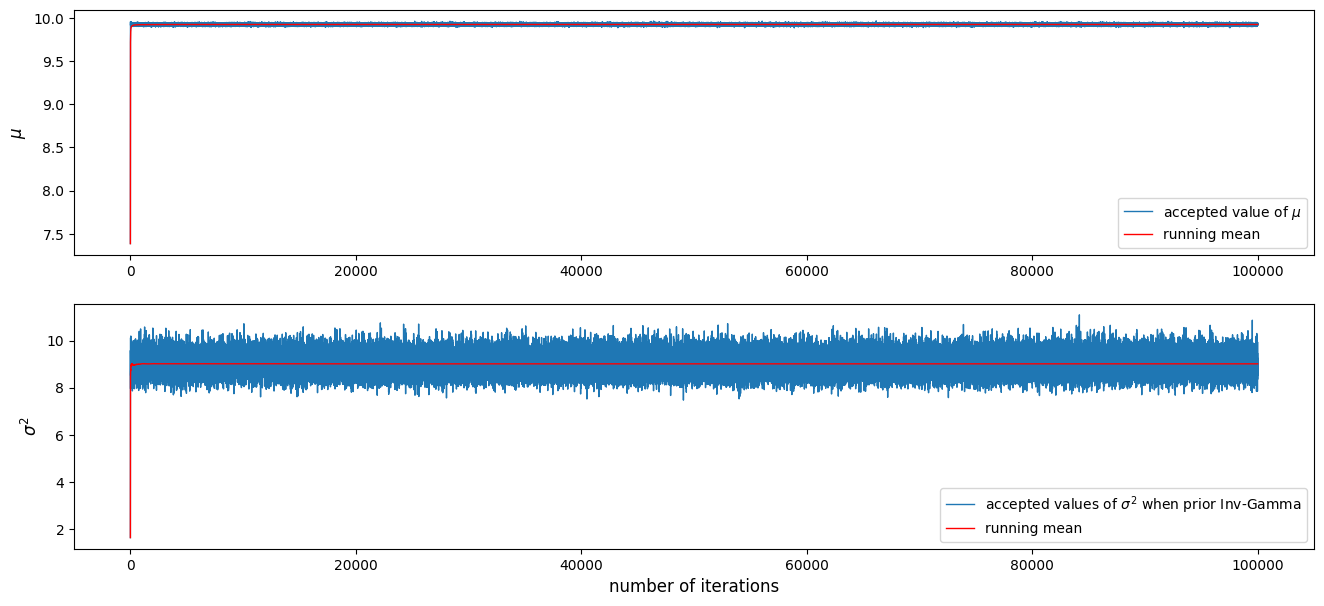

In [11]:
plt.figure(figsize=(16, 7))

# for mu
plt.subplot(211)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=sample[0],
    linewidth=1,
    label=r"accepted value of $\mu$",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=RunningMeans(sample[0]),
    color="r",
    linewidth=1,
    label="running mean",
)
# plt.xlabel("number of iterations", fontsize=12)
plt.ylabel(r"$\mu$", fontsize=12)

# for sigma
plt.subplot(212)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=sample[1],
    linewidth=1,
    label=r"accepted values of $\sigma^2$ when prior Inv-Gamma",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=RunningMeans(sample[1]),
    color="r",
    linewidth=1,
    label="running mean",
)
plt.xlabel("number of iterations", fontsize=12)
plt.ylabel(r"$\sigma^2$", fontsize=12)

Text(0.5, 0, '$\\sigma^2$')

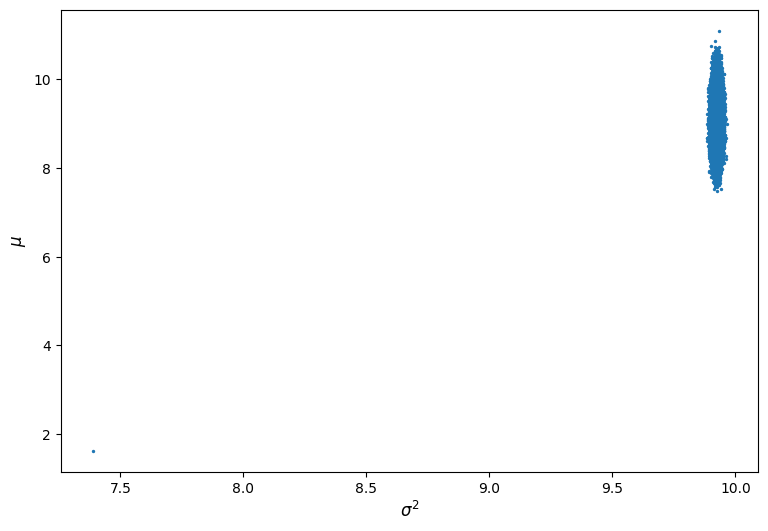

In [12]:
plt.figure(figsize=(9, 6))
plt.scatter(sample[0], sample[1], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

after burn in


<Axes: xlabel='Density'>

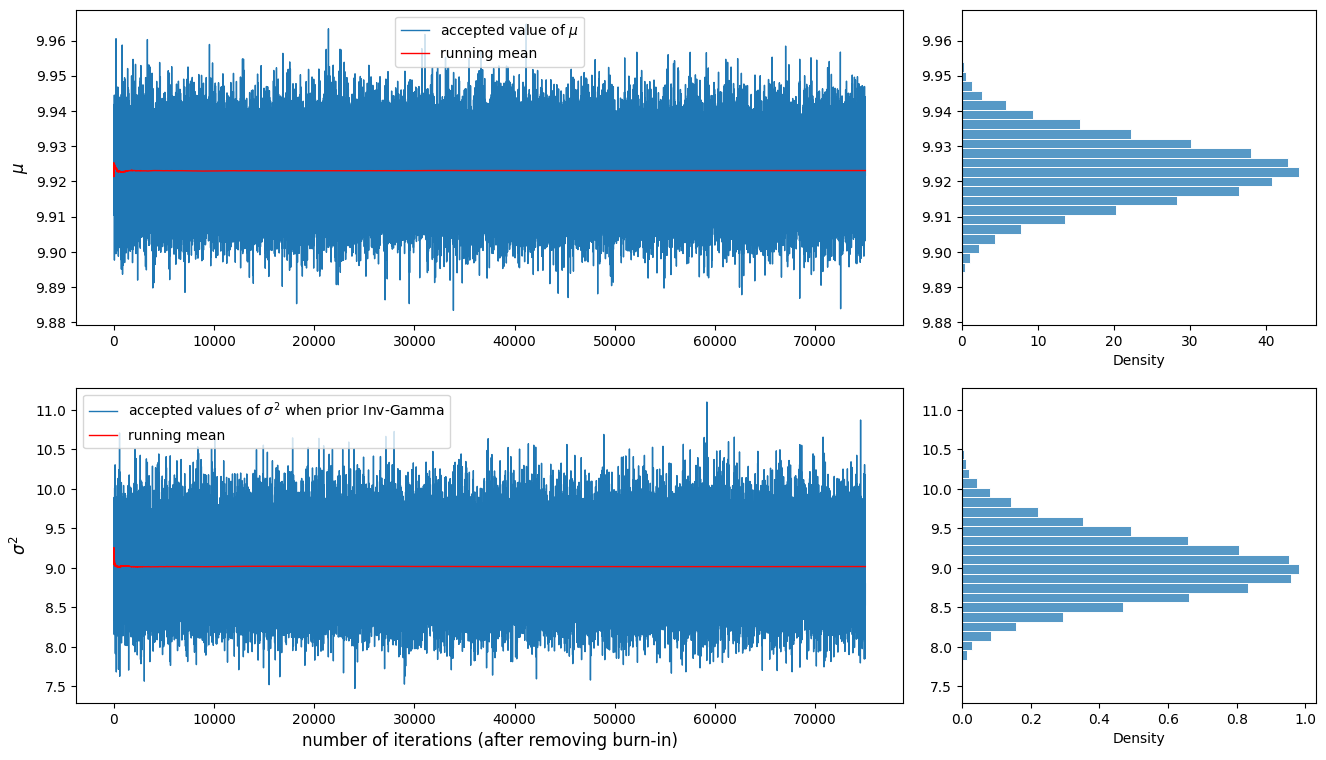

In [24]:
plt.figure(figsize=(16, 9))
gs = GridSpec(2, 2, width_ratios=[7, 3], wspace=0.1)

# for mu
plt.subplot(gs[0, 0])
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=sample[0][burn_in:],
    linewidth=1,
    label=r"accepted value of $\mu$",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=RunningMeans(sample[0][burn_in:]),
    color="r",
    linewidth=1,
    label="running mean",
)
plt.ylabel(r"$\mu$", fontsize=12)

# hist of mu
plt.subplot(gs[0, 1])
sns.histplot(y=sample[0][burn_in:], bins=30, edgecolor="w", stat="density")

# for sigma
plt.subplot(gs[1, 0])
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=sample[1][burn_in:],
    linewidth=1,
    label=r"accepted values of $\sigma^2$ when prior Inv-Gamma",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=RunningMeans(sample[1][burn_in:]),
    color="r",
    linewidth=1,
    label="running mean",
)
plt.xlabel("number of iterations (after removing burn-in)", fontsize=12)
plt.ylabel(r"$\sigma^2$", fontsize=12)

# hist for sigma
plt.subplot(gs[1, 1])
sns.histplot(y=sample[1][burn_in:], bins=30, edgecolor="w", stat="density")

Text(0.5, 0, '$\\sigma^2$')

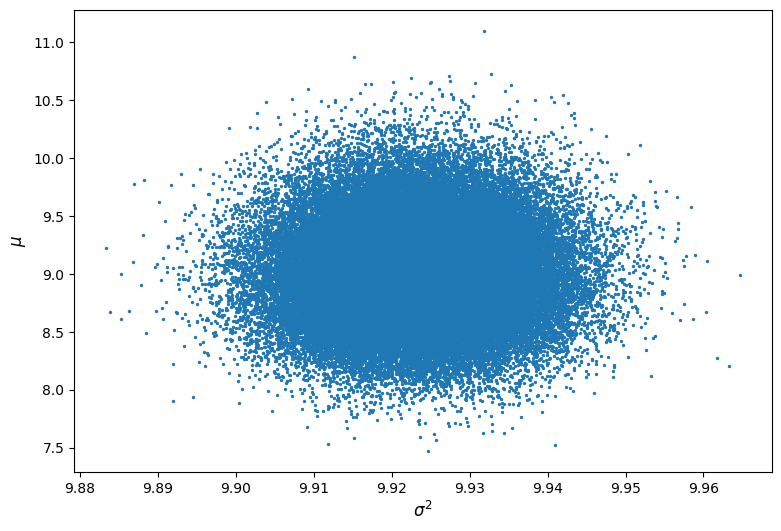

In [14]:
plt.figure(figsize=(9, 6))
plt.scatter(sample[0][burn_in:], sample[1][burn_in:], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

## using Scaled inverse chisqure


In [15]:
sample2 = [
    [np.random.normal(mu0, np.sqrt(sigma02))],
    [sigma02 * v / np.random.chisquare(v)],
]
for _ in range(SAMPLE_SIZE):
    current_sigma = sample2[1][-1]
    mu_post_mean = (1 / ((1 / sigma02) + (len(observation) / current_sigma))) * (
        (mu0 / sigma02) + (observation.sum() / current_sigma)
    )
    mu_post_scale = (sigma02 * current_sigma) / (
        len(observation) * sigma02 + current_sigma
    )
    new_mu = np.random.normal(mu_post_mean, mu_post_scale)
    sigma_post_df = v + len(observation)
    sigma_post_scale = (
        v * sigma02 + np.sum((observation - new_mu) ** 2)
    ) / sigma_post_df
    new_sigma = sigma_post_scale * sigma_post_df / np.random.chisquare(sigma_post_df)
    sample2[0].append(new_mu)
    sample2[1].append(new_sigma)

sample2 = np.array(sample2)
sample2

array([[10.12276511,  9.9233392 ,  9.90752137, ...,  9.91615516,
         9.93635882,  9.91044283],
       [ 4.71180211,  8.76836819, 10.24881257, ...,  9.56995978,
         9.06582682,  8.76316966]])

In [16]:
sample2[0].mean()

9.923018847484718

In [17]:
sample2[1].mean()

9.025883609686353

Text(0, 0.5, '$\\sigma^2$')

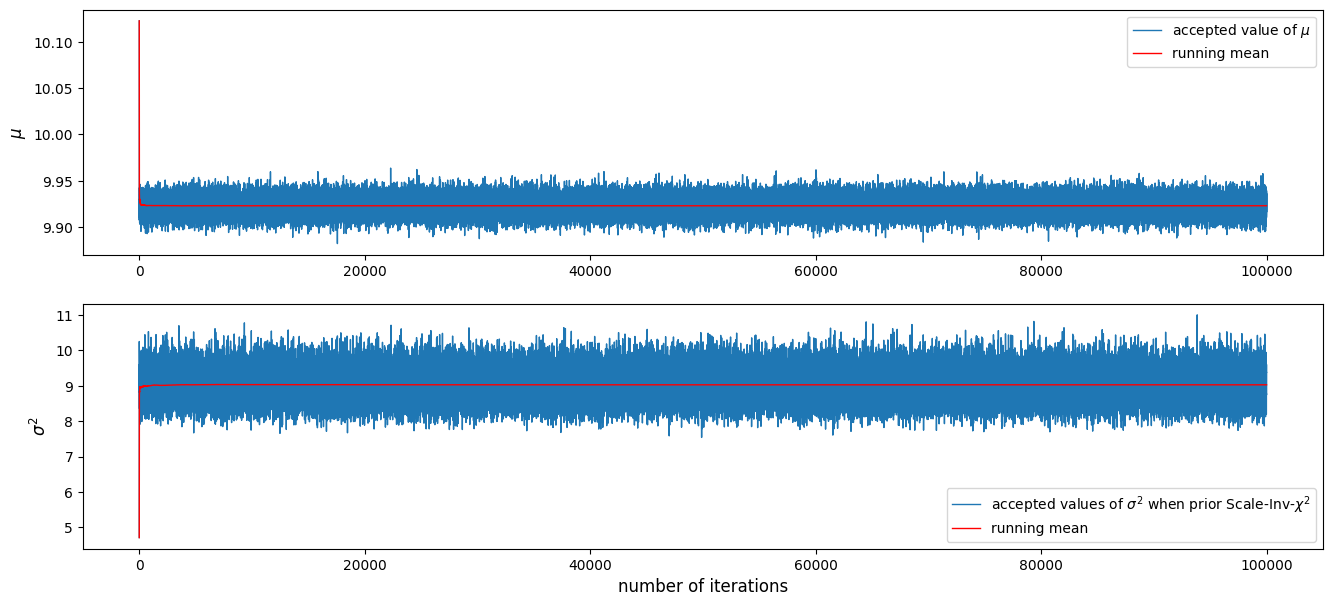

In [25]:
plt.figure(figsize=(16, 7))

# for mu
plt.subplot(211)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=sample2[0],
    linewidth=1,
    label=r"accepted value of $\mu$",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=RunningMeans(sample2[0]),
    color="r",
    linewidth=1,
    label="running mean",
)
# plt.xlabel("number of iterations", fontsize=12)
plt.ylabel(r"$\mu$", fontsize=12)

# for sigma
plt.subplot(212)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=sample2[1],
    linewidth=1,
    label=r"accepted values of $\sigma^2$ when prior Scale-Inv-$\chi^2$",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1),
    y=RunningMeans(sample2[1]),
    color="r",
    linewidth=1,
    label="running mean",
)
plt.xlabel("number of iterations", fontsize=12)
plt.ylabel(r"$\sigma^2$", fontsize=12)

Text(0.5, 0, '$\\sigma^2$')

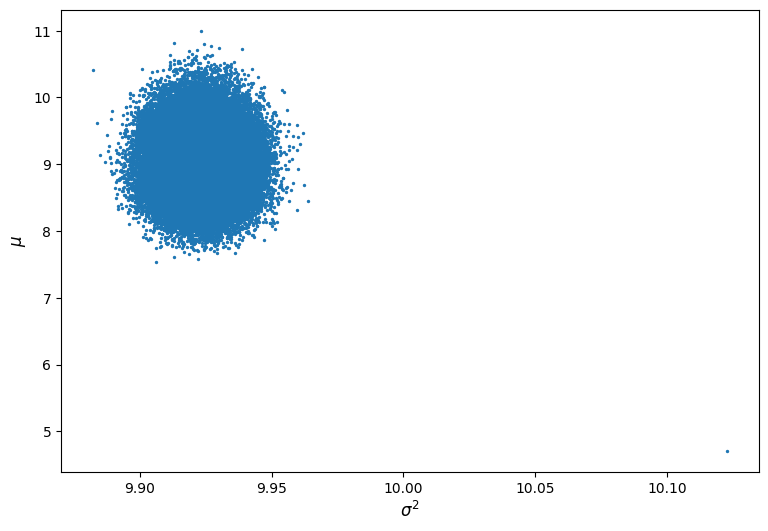

In [19]:
plt.figure(figsize=(9, 6))
plt.scatter(sample2[0], sample2[1], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

after removing burn-in


<Axes: xlabel='Density'>

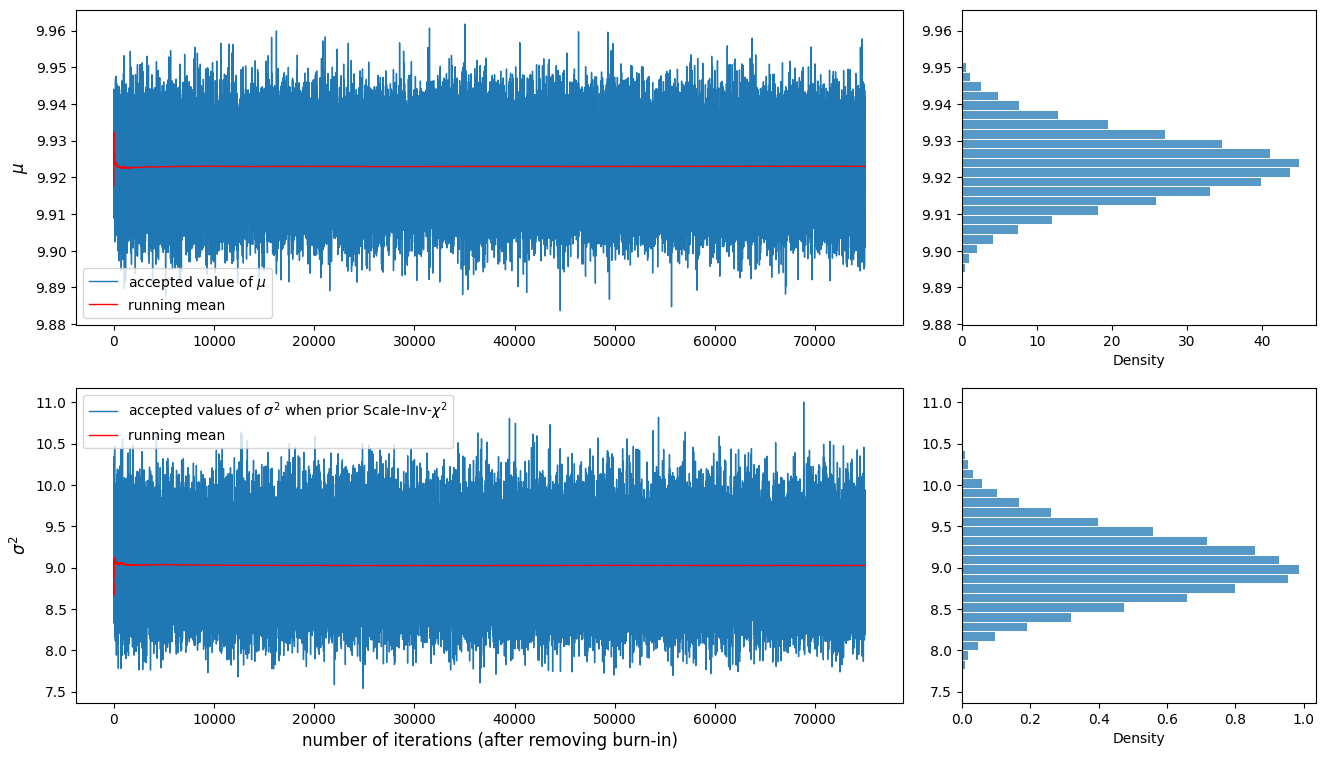

In [27]:
plt.figure(figsize=(16, 9))
gs = GridSpec(2, 2, width_ratios=[7, 3], wspace=0.1)

# for mu
plt.subplot(gs[0, 0])
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=sample2[0][burn_in:],
    linewidth=1,
    label=r"accepted value of $\mu$",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=RunningMeans(sample2[0][burn_in:]),
    color="r",
    linewidth=1,
    label="running mean",
)
plt.ylabel(r"$\mu$", fontsize=12)

# hist of mu
plt.subplot(gs[0, 1])
sns.histplot(y=sample2[0][burn_in:], bins=30, edgecolor="w", stat="density")

# for sigma
plt.subplot(gs[1, 0])
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=sample2[1][burn_in:],
    linewidth=1,
    label=r"accepted values of $\sigma^2$ when prior Scale-Inv-$\chi^2$",
)
sns.lineplot(
    x=range(SAMPLE_SIZE + 1 - burn_in),
    y=RunningMeans(sample2[1][burn_in:]),
    color="r",
    linewidth=1,
    label="running mean",
)
plt.xlabel("number of iterations (after removing burn-in)", fontsize=12)
plt.ylabel(r"$\sigma^2$", fontsize=12)

# hist of sigma
plt.subplot(gs[1, 1])
sns.histplot(y=sample2[1][burn_in:], bins=30, edgecolor="w", stat="density")

Text(0.5, 0, '$\\sigma^2$')

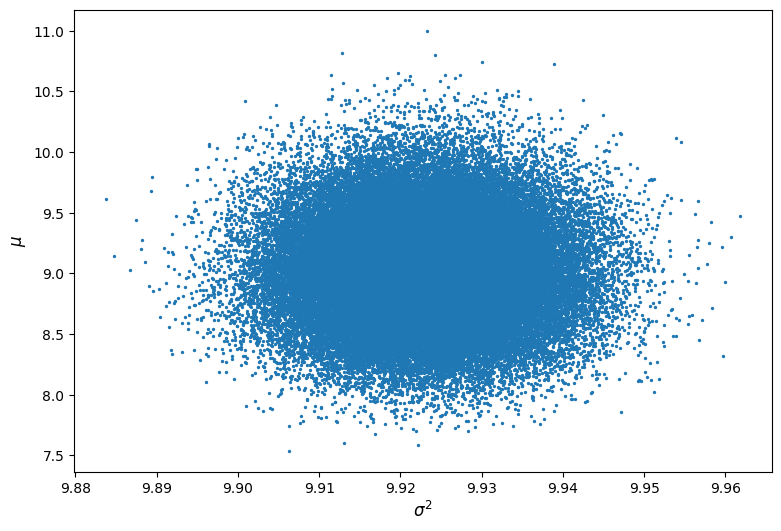

In [21]:
plt.figure(figsize=(9, 6))
plt.scatter(sample2[0][burn_in:], sample2[1][burn_in:], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

## Comparism


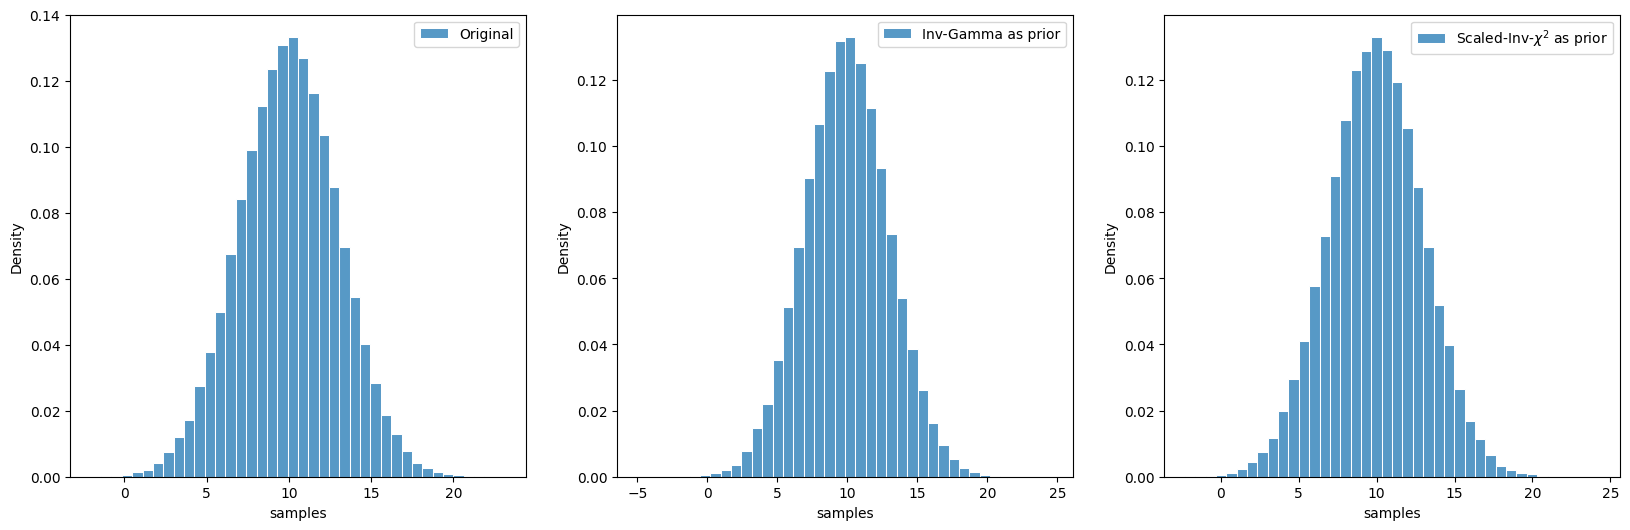

In [22]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.histplot(
    population,
    bins=40,
    edgecolor="w",
    label="Original",
    stat="density",
)
plt.xlabel("samples")
plt.legend()
plt.subplot(1, 3, 2)
sns.histplot(
    np.random.normal(sample[0][burn_in:].mean(), np.sqrt(sample[1][burn_in:].mean()), SAMPLE_SIZE),
    bins=40,
    edgecolor="w",
    label=r"Inv-Gamma as prior",
    stat="density",
)
plt.xlabel("samples")
plt.legend()
plt.subplot(1, 3, 3)
sns.histplot(
    np.random.normal(sample2[0][burn_in:].mean(), np.sqrt(sample2[1][burn_in:].mean()), SAMPLE_SIZE),
    edgecolor="w",
    bins=40,
    label=r"Scaled-Inv-$\chi^2$ as prior",
    stat="density",
)
plt.xlabel("samples")
plt.legend()